In [13]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from tqdm import tqdm
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.linear_model import BayesianRidge
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import OrdinalEncoder
from sklearn import preprocessing

from sklearn.model_selection import cross_val_score
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline

import warnings
warnings.filterwarnings('ignore')

In [5]:
#df=pd.read_csv('vehicles.csv')
df=pd.read_csv('../data/raw/dataset.csv')
df=pd.DataFrame(df)
df.head()
df.columns

Index(['id', 'url', 'region', 'region_url', 'price', 'year', 'manufacturer',
       'model', 'condition', 'cylinders', 'fuel', 'odometer', 'title_status',
       'transmission', 'VIN', 'drive', 'size', 'type', 'paint_color',
       'image_url', 'description', 'county', 'state', 'lat', 'long',
       'posting_date'],
      dtype='object')

In [6]:
df2=df.copy()
df2=df2.drop(columns=['url','region_url','VIN','image_url','description','county','state'])
df2.head()

,id,region,price,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,drive,size,type,paint_color,lat,long,posting_date
0,7317047999,new york city,119500,2002.0,NaN,HUMMER H1,NaN,8 cylinders,diesel,61816.0,clean,automatic,4wd,NaN,SUV,black,25.827103,-80.24152,2021-05-04T20:56:55-0400
1,7317047319,new york city,2999,2007.0,nissan,quest 3.5 se,good,6 cylinders,gas,120679.0,clean,other,fwd,full-size,mini-van,silver,40.632400,-74.11710,2021-05-04T20:55:05-0400
2,7317046012,new york city,11000,2010.0,infiniti,ex35 journey,excellent,6 cylinders,gas,90700.0,clean,automatic,4wd,mid-size,SUV,grey,40.917700,-73.89500,2021-05-04T20:51:31-0400
3,7317045906,new york city,19995,2017.0,lexus,is,NaN,NaN,gas,66074.0,clean,automatic,4wd,NaN,sedan,white,40.816030,-73.46397,2021-05-04T20:51:10-0400
4,7317044354,new york city,2899,2003.0,nissan,murano sl awd,good,6 cylinders,gas,189000.0,clean,automatic,4wd,mid-size,SUV,silver,40.620500,-73.92390,2021-05-04T20:46:56-0400


In [7]:
df2.isnull().sum()

id                 0
region             0
price              0
year              21
manufacturer     562
model            133
condition       4734
cylinders       5016
fuel              48
odometer          64
title_status     222
transmission      85
drive           4444
size            8572
type            2416
paint_color     3383
lat               44
long              44
posting_date       2
dtype: int64

In [8]:
num_col=['year','odometer','lat','long']
cat_cols=['region','manufacturer','model','condition','cylinders','fuel','title_status', 'transmission', 'drive', 'size', 'type', 'paint_color', 'posting_date' ]

In [14]:
check_imputer=df2.copy()
check_imputer=check_imputer.drop(columns=['id'])

#object of LabelEncoder
encoder=preprocessing.LabelEncoder()

#function to label the categorical columns ignoring null values 
def encode(data):
    #retains only non-null values
    nonulls = np.array(data.dropna())
    #reshapes the data for encoding
    impute_reshape = nonulls.reshape(-1,1)
    #encode date
    impute_ordinal = encoder.fit_transform(impute_reshape)
    #Assign back encoded values to non-null values
    data.loc[data.notnull()] = np.squeeze(impute_ordinal)
    return data

#loop to label each column or categorical values into numberic
for i in tqdm(range(len(cat_cols))):
    encode(check_imputer[cat_cols[i]])

  0%|          | 0/13 [00:00<?, ?it/s]

100%|██████████| 13/13 [00:00<00:00, 93.69it/s] 


In [16]:
# Estimate the score on the entire dataset by filling missing values by 4 different iterative imputer


#estimators for IterativeImputer
estimators = [
    BayesianRidge(),
    DecisionTreeRegressor(max_features='sqrt', random_state=0),
    ExtraTreesRegressor(n_estimators=10, random_state=0),
    KNeighborsRegressor(n_neighbors=15)
]
score_iterative_imputer = pd.DataFrame()
for esti in estimators:
        print("Estimating",esti.__class__.__name__)
        imputer = IterativeImputer(esti)
        df_new=check_imputer.copy()
        for col in check_imputer.columns:
            #col=check_imputer.columns[i]
            impute_data=imputer.fit_transform(df_new[col].values.reshape(-1,1))
            impute_data=impute_data.astype('int64')
            impute_data = pd.DataFrame(np.ravel(impute_data))
            df_new[col]=impute_data
        X=df_new.iloc[:,:-1]
        #y=check_imputer.iloc[:,-1:].values.ravel()
        y = np.ravel(df_new.iloc[:,-1:])
        score_iterative_imputer[esti.__class__.__name__] = cross_val_score(esti,X,y,scoring='neg_mean_squared_error',cv=6)

Estimating BayesianRidge
Estimating DecisionTreeRegressor
Estimating ExtraTreesRegressor
Estimating KNeighborsRegressor


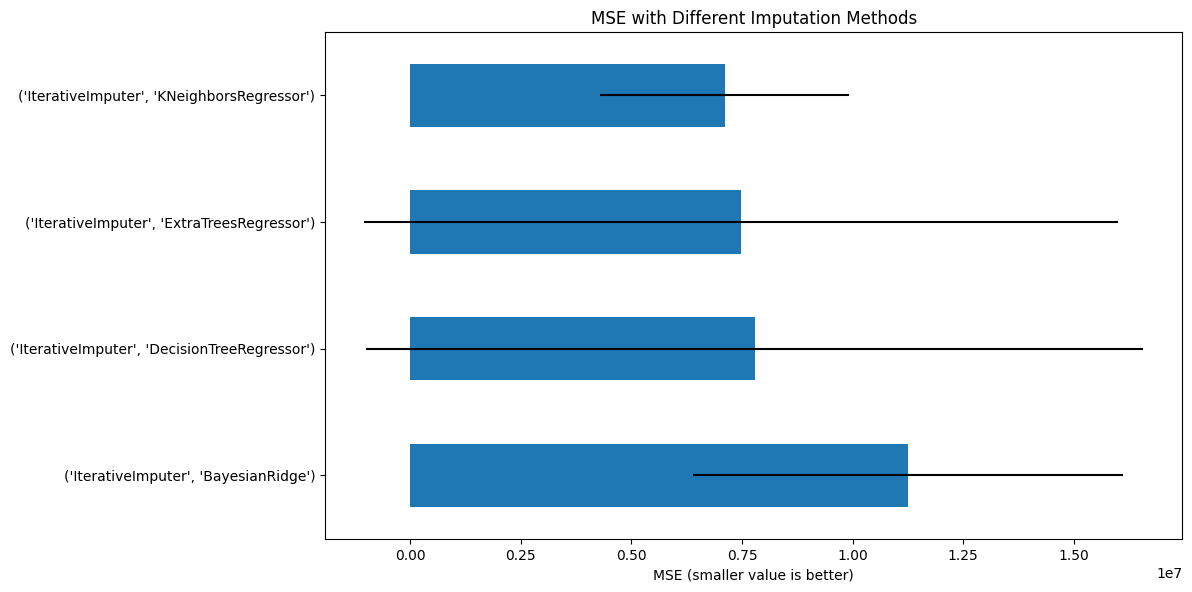

In [17]:
#ploting the graphs of scores each method
scores = pd.concat(
    [score_simple_imputer, score_iterative_imputer],
    keys=['SimpleImputer', 'IterativeImputer'], axis=1
)
fig, ax = plt.subplots(figsize=(12, 6))
means = -scores.mean()
errors = scores.std()
means.plot.barh(xerr=errors, ax=ax)
ax.set_title('MSE with Different Imputation Methods')
ax.set_xlabel('MSE (smaller value is better)')
ax.set_yticks(np.arange(means.shape[0]))
ax.set_yticklabels(means.index.tolist())
plt.tight_layout(pad=1)
plt.savefig('different-imputations-method',dpi=None)
plt.show()

In [18]:
df2.isnull().sum()[num_col]

year        21
odometer    64
lat         44
long        44
dtype: int64

In [19]:
data_num=df2[num_col]
imputer_num=IterativeImputer(estimators[2]) #estimators[2] = ExtraTreesRegressor
impute_data=imputer_num.fit_transform(data_num)
df2[num_col]=impute_data

In [20]:
#Missing values after filling
df2.isnull().sum()[num_col]

year        0
odometer    0
lat         0
long        0
dtype: int64

In [21]:
#Missing values before filling
df2.isnull().sum()[cat_cols]

region             0
manufacturer     562
model            133
condition       4734
cylinders       5016
fuel              48
title_status     222
transmission      85
drive           4444
size            8572
type            2416
paint_color     3383
posting_date       2
dtype: int64

In [22]:
data_cat=df2[cat_cols]
encoder=preprocessing.LabelEncoder()

#create a for loop to iterate through each column in the data
for columns in cat_cols:
    encode(data_cat[columns])
    imputer = IterativeImputer(BayesianRidge())
    impute_data=imputer.fit_transform(data_cat[columns].values.reshape(-1, 1))
    impute_data=impute_data.astype('int64')
    impute_data = pd.DataFrame(impute_data)
    impute_data =encoder.inverse_transform(impute_data.values.reshape(-1, 1))
    data_cat[columns]=impute_data
df2[cat_cols]=data_cat    

In [23]:
#Missing values after filling
df2.isnull().sum()[cat_cols]

region          0
manufacturer    0
model           0
condition       0
cylinders       0
fuel            0
title_status    0
transmission    0
drive           0
size            0
type            0
paint_color     0
posting_date    0
dtype: int64

In [24]:
#No null value in the dataset 
df2.isnull().sum()

id              0
region          0
price           0
year            0
manufacturer    0
model           0
condition       0
cylinders       0
fuel            0
odometer        0
title_status    0
transmission    0
drive           0
size            0
type            0
paint_color     0
lat             0
long            0
posting_date    0
dtype: int64

In [25]:
df2.to_csv('processed.csv',index=False)